In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import sys
from collections import defaultdict

if '../' not in sys.path:
    sys.path.append('../')

from lib.envs.blackjack import BlackjackEnv
from lib import plots

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_eps_greedy_policy(Q, epsilon, nA):
    """
    Create an epsilon greedy policy based on given action values and epsilon.
    Args:
        Q: Dictionary mapping state to action values. Each value is a numpy
           array of length nA
        epsilon: The probability to select a random action. (float between 0 and 1)
        nA: Number of actions in the env.
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policy_fn(observations):
        # create action probabilities numpy array
        action_probs = np.ones(nA, dtype=float) * (epsilon/nA)
        
        # argmax Q for given observation to get 
        # the best action for current state
        A_star = np.argmax(Q[observations])
        
        # update best_action_prob
        action_probs[A_star] += 1.0 - epsilon
        return action_probs
    
    return policy_fn

In [4]:
def monte_carlo_control(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte carlo control using epsilon greedy policies. Finds an
    optimal eps-greedy policy.
    Args:
        env: The OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma
        epsilon: The probability to select a random action. (float between 0 and 1)
    Returns:
        A tuple (Q, policy).
        Q: Dictionary mapping state -> action values.
        policy: a function that takes an observation as an argument and returns
        action probabilities
    """
    # initialize
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # create action values dict
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # create policy function 
    policy = create_eps_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    # loop through num_episodes
    for episode in range(num_episodes):
        if (episode+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode+1, num_episodes), end="")
            sys.stdout.flush()
        # Generate an episode
        trajectory = []
        
        # reset and get initial state
        state = env.reset()
        for time_step in range(100):
            # get action probabilities
            action_probs = policy(state)
            
            # sample action based on state
            action = np.random.choice(np.arange(env.action_space.n), p=action_probs)
            
            # environment's effects after an action is taken
            next_state, reward, done, _ = env.step(action)
            
            trajectory.append((state, action, reward))
            if done:
                break
            
            # update current state
            state = next_state
            
        # update q value function
        # get all the visited states in the episode
        state_actions = set([(tuple(x[0]), x[1]) for x in trajectory])
        
        for state, action in state_actions:
            sa = (state, action)
            # find first occurence of state_action pair
            first_occ = next(i for i, x in enumerate(trajectory) if x[0]==state and x[1]==action)
            
            # calculate return from that time step
            G = np.sum([x[2]*(discount_factor**i) for i, x in enumerate(trajectory[first_occ:])])
            
            returns_sum[sa] += G
            returns_count[sa] += 1
            
            Q[state][action] = returns_sum[sa]/returns_count[sa]
            
        # update policy
        # No need for this as policy is update implicitly by changing Q   
        # policy = create_eps_greedy_policy(Q, epsilon, env.action_space.n)  
    return Q, policy

In [5]:
Q, policy = monte_carlo_control(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

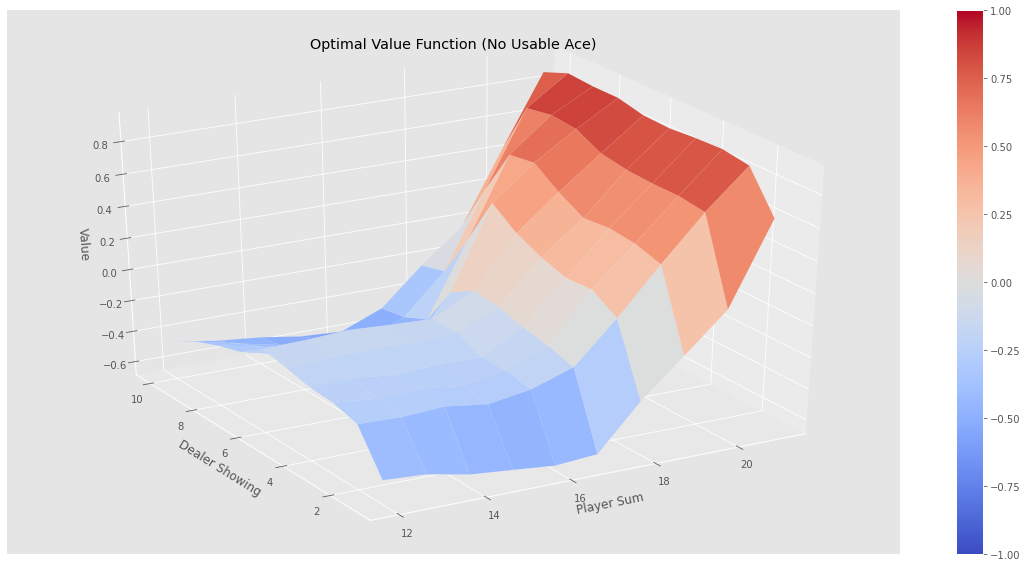

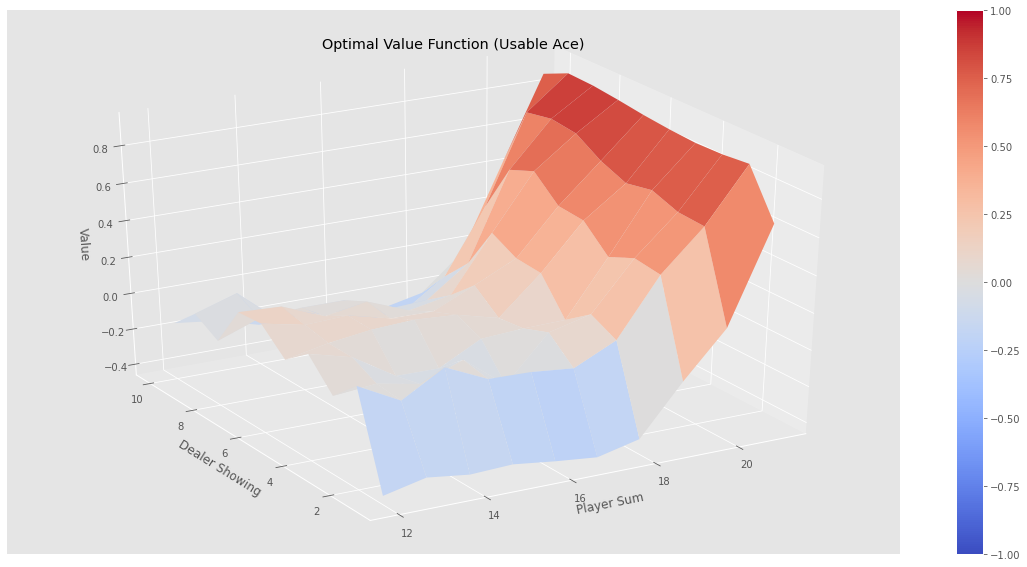

In [6]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
policy = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
    policy[state] = np.argmax(actions)
plots.plot_value_function(V, title="Optimal Value Function")

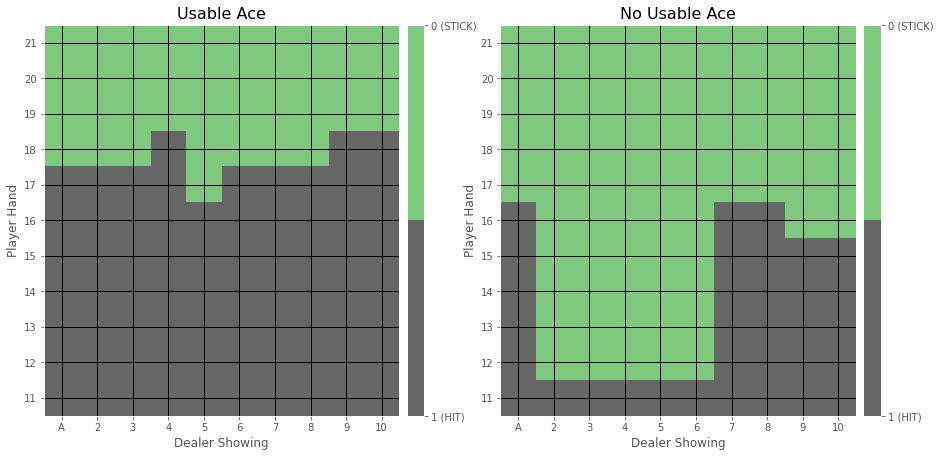

In [7]:
plots.plot_policy(policy, plot_filename=None)